In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
from sklearn.model_selection import train_test_split
path="/its/home/drs25/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
datapath="/its/home/drs25/Documents/data/Tactile Dataset/datasets/"
if os.name == 'nt':
    path="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/"
    datapath="C:/Users/dexte/Documents/GitHub/RoboSkin/Code/NewRigExperiments/texture-tactip/"
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"
from sklearn.linear_model import Ridge
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print(f"Using device: {device}")
from itertools import islice

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))


/its/home/drs25/miniconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Using device: cpu


# load in datasets

In [2]:
class loaded:
    def __init__(self,t=20,filename="X_data_15.npz"):
        data = np.load(datapath+filename) #load data
        for array_name in data:
            self.X=(data[array_name].astype(np.uint8))
        data = np.load(datapath+filename.replace("X","y")) #load data
        for array_name in data:
            self.y=(data[array_name].astype(np.uint8))
        self.keys=['Leather', 'Cork', 'wool', 'LacedMatt', 'Gfoam', 'Plastic', 'Carpet', 'bubble', 'Efoam', 'cotton', 'LongCarpet', 'Flat', 'felt', 'Jeans', 'Ffoam']

        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        self.X=self.X[:,0:t]
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def shuffle(self):
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def augment(self):
        #create rotations
        self.AugmentedX=np.zeros((len(self.X)*3,*self.X.shape[1:]),dtype=np.uint8)
        self.Augmentedy=np.zeros_like(np.concatenate((self.y,self.y,self.y)))
        for k,i in enumerate(range(0,len(self.AugmentedX),3)): #loop through the normal data and new data
            for j in range(len(self.X[0])):
                self.AugmentedX[i][j]=np.copy(self.X[k][j])
                self.AugmentedX[i+1][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_90_CLOCKWISE),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.AugmentedX[i+2][j]=cv2.resize(cv2.rotate(self.X[k][j].copy(), cv2.ROTATE_180),(self.X[k][j].shape[1],self.X[k][j].shape[0]),interpolation=cv2.INTER_AREA)
                self.Augmentedy[i+1]=self.y[k]
                self.Augmentedy[i+2]=self.y[k]
                self.Augmentedy[i]=self.y[k]
                #self.AugmentedX[i+3][j]=cv2.rotate(self.X[k][j], cv2.ROTATE_90_COUNTERCLOCKWISE)
        print("Dataset size:",self.AugmentedX.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.AugmentedX)/ 1024 / 1024/ 1024,2),"GB")
        self.X = self.AugmentedX
        self.y = self.Augmentedy
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
        del self.AugmentedX
        del self.Augmentedy
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

    def resize(self,percentage):
        h=int(self.X.shape[2]*percentage)
        w=int(self.X.shape[3]*percentage)
        new_array=np.zeros((*self.X.shape[0:2],h,w))

        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                iamge = cv2.resize(image,(w,h),interpolation=cv2.INTER_AREA)
                new_array[i][j]=iamge
        self.X=new_array.copy()
#data=loaded(t=13)
#data.applySobel()
#data.augment()

# convert data labels to friction 

In [80]:
data=loaded(t=4)
data.applySobel()
#data.augment()

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


In [17]:
data_ = np.load(datapath+"X_data_presstip.npz") #load data
X=None
for array_name in data_:
    X=data_[array_name]
X=(X* 3.3) / 65536 #convert to voltage
data_ = np.load(datapath+"y_data_presstip.npz") #load data
y=None
for array_name in data_:
    y=data_[array_name]
print(X.shape,y.shape)


(3000, 20, 16) (3000,)


In [20]:
def relabel(d):
    global friction_dict
    the_ys=d.copy().astype(np.float64)
    labels = [
        "ffoam", "flat", "plastic", "leather", "cork", 
        "longcarpet", "carpet", "gfoam", "efoam", 
        "lacedmatt", "jeans", "wool", "bubble", "felt", "cotton"
    ]

    # Corresponding friction values
    values = [
        0.923363636363636, 0.383908045977011, 0.354716981132075, 
        0.951428571428571, 0.642957746478873, 0.484507042253521, 
        0.323076923076923, 0.5125, 0.383787878787879, 0.37453125, 
        0.444262295081967, 0.2945, 0.484745762711864, 0.533898305084746, 
        0.6745
    ]

    # Creating the dictionary
    friction_dict = dict(zip(labels, values))
    friction_dict
    keys=[x.lower() for x in data.keys]
    for i in range(len(keys)):
        friction=friction_dict[keys[i]]
        the_ys[np.where(the_ys==i)[0]]=friction
    return the_ys
data.y=relabel(data.y)
y=relabel(y)

# modelling

## regression

In [28]:
#tactip
alpha = 0.5  # Regularization parameter
# Fit and transform the label data
X_train, X_test, y_train, y_test = train_test_split(data.X.reshape((len(data.X),-1)),data.y, test_size=0.2, random_state=42)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_test)
a=np.round(predictions,1)-np.round(y_test,1)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(predictions-y_test))/len(predictions))


Accuracy 42.833333333333336 %
average loss 0.00795923870613888


In [9]:
#test res
alpha=0.5
resolutions=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.7,0.8,0.9,1]
acc_test=[]
acc_train=[]
loss_test=[]
loss_train=[]

for i, res in enumerate(resolutions):
    #load data
    data=loaded(t=4)
    data.applySobel()
    data.resize(res)
    data.y=relabel(data.y)
    X_train, X_test, y_train, y_test = train_test_split(data.X.reshape((len(data.X),-1)),data.y, test_size=0.2, random_state=42)
    # Define the Ridge regression model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    predictions = ridge_model.predict(X_test)
    a=np.round(predictions,1)-np.round(y_test,1)
    correct=len(a[a==0])
    acc_test.append(correct/len(a)*100)
    loss_test.append(np.sum(np.absolute(predictions-y_test))/len(predictions))
    predictions = ridge_model.predict(X_train)
    a=np.round(predictions,1)-np.round(y_train,1)
    correct=len(a[a==0])
    acc_train.append(correct/len(a)*100)
    loss_train.append(np.sum(np.absolute(predictions-y_train))/len(predictions))

    print("Accuracy",correct/len(a)*100,"%")
    
    np.save(path+"data/acc_test_regression_friction_"+str(res).replace(".","-"),np.array(acc_test))
    np.save(path+"data/acc_train_regression_friction_"+str(res).replace(".","-"),np.array(acc_train))
    np.save(path+"data/loss_test_regression_friction_"+str(res).replace(".","-"),np.array(loss_test))
    np.save(path+"data/loss_train_regression_friction_"+str(res).replace(".","-"),np.array(loss_train))


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 52.416666666666664 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 79.25 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 87.29166666666667 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 93.66666666666667 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
Accuracy 100.0 %
Dataset size:

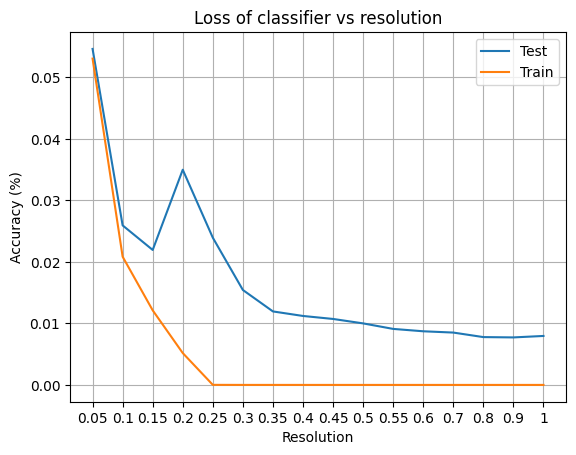

In [15]:
#plt.plot(acc_test,label="Test")
#plt.plot(acc_train,label="Train")
plt.plot(loss_test,label="Test")
plt.plot(loss_train,label="Train")
plt.legend()
plt.grid(True)
plt.title("Loss of classifier vs resolution")
plt.ylabel("Accuracy (%)")
plt.xlabel("Resolution")
plt.xticks([i for i in range(len(acc_train))],resolutions)
plt.savefig(path+"/images/resolutionfrictionloss.pdf")
plt.show()

In [26]:
# presstip
alpha = 0.5  # Regularization parameter
# Fit and transform the label data
piezoeelectric=X[:,8]
accelerometer=X[:,9:12]
both=X[:,8:12]
X_train, X_test, y_train, y_test = train_test_split(piezoeelectric.reshape((len(X),-1)),y, test_size=0.2, random_state=42)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_test)
a=np.round(predictions,1)-np.round(y_test,1)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(predictions-y_test))/len(predictions))


Accuracy 23.166666666666664 %
average loss 0.14115648097314656


/tmp/ipykernel_3929/1392950122.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colours = plt.cm.get_cmap('tab20', 15).colors  # 15 distinct colors for the 15 materials
/tmp/ipykernel_3929/1392950122.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(predictions[i],y_test[i],c=colours[dict_[class_]],label=class_)
/tmp/ipykernel_3929/1392950122.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

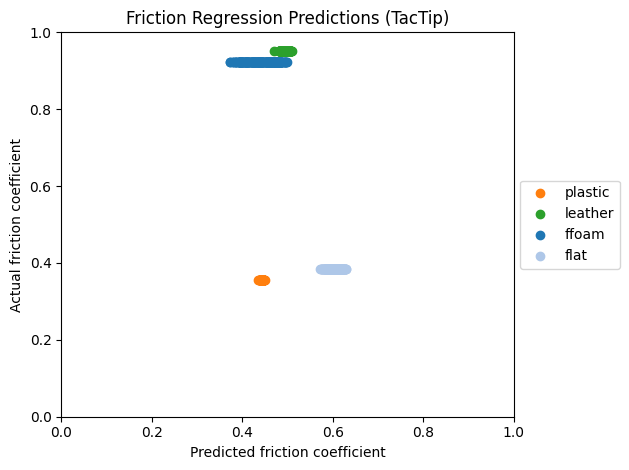

In [51]:

reveresed={np.round(v,5): k for k, v in friction_dict.items()}
colours = plt.cm.get_cmap('tab20', 15).colors  # 15 distinct colors for the 15 materials
dict_={v[1]: i for i,v in enumerate(reveresed.items())}
found=[]
for i in range(len(y_test)):
    class_=reveresed[np.round(y_test[i],5)]
    if class_ in found:
        plt.scatter(predictions[i],y_test[i],c=colours[dict_[class_]])
    else:
        plt.scatter(predictions[i],y_test[i],c=colours[dict_[class_]],label=class_)
        found.append(class_)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Friction Regression Predictions (TacTip)")
plt.xlabel("Predicted friction coefficient")
plt.ylabel("Actual friction coefficient")
plt.xlim([0,1])
plt.ylim([0,1])
plt.tight_layout()  # Adds space on the right for the legend
plt.savefig(path+"/images/friction_optical_unseen.pdf")
plt.show()

### take out some textures

In [50]:
#tactip
alpha = 0.5  # Regularization parameter
# Fit and transform the label data
reveresed_segment={np.round(v,5): k for k, v in take(4,friction_dict.items())}
new_dataX=[]
old_dataX=[]
new_datay=[]
old_datay=[]
for i in range(len(data.X)):
    if np.round(data.y[i],5) in list(reveresed_segment.keys()):
        new_datay.append(data.y[i])
        new_dataX.append(data.X[i])

    else:
        old_datay.append(data.y[i])
        old_dataX.append(data.X[i])

new_dataX=np.array(new_dataX)
new_datay=np.array(new_datay)
old_dataX=np.array(old_dataX)
old_datay=np.array(old_datay)
print(new_dataX.shape,old_dataX.shape)
new_dataX=new_dataX.reshape(len(new_dataX),-1)
old_dataX=old_dataX.reshape(len(old_dataX),-1)
# Define the Ridge regression model
ridge_model = Ridge(alpha=alpha)
ridge_model.fit(old_dataX, old_datay)
predictions = ridge_model.predict(new_dataX)
a=np.round(predictions,1)-np.round(new_datay,1)
correct=len(a[a==0])
print("Accuracy",correct/len(a)*100,"%")
print("average loss",np.sum(np.absolute(predictions-new_datay))/len(predictions))
y_test=new_datay

(800, 4, 110, 120) (2200, 4, 110, 120)
Accuracy 25.0 %
average loss 0.31186350046694505


## neural

(800, 4, 110, 120) (2200, 4, 110, 120)
